# ECP Homework 4
## _Group Members: Pranjal Sharma, Moritz Hinkel_

Imports

In [1]:
import sys
!{sys.executable} -m pip install pyltspice matplotlib

pyltspice needs to be installed via pip (conda does not seem to have it)!

In [2]:
from PyLTSpice import SimRunner, SpiceEditor, LTspice, RawRead
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PWL.IMPLY_PWL import Memristor, SerialArchitecture

### Architecture

Screenshot of the Serial Architecture for the 3 Bit Adder taken from LTSpice

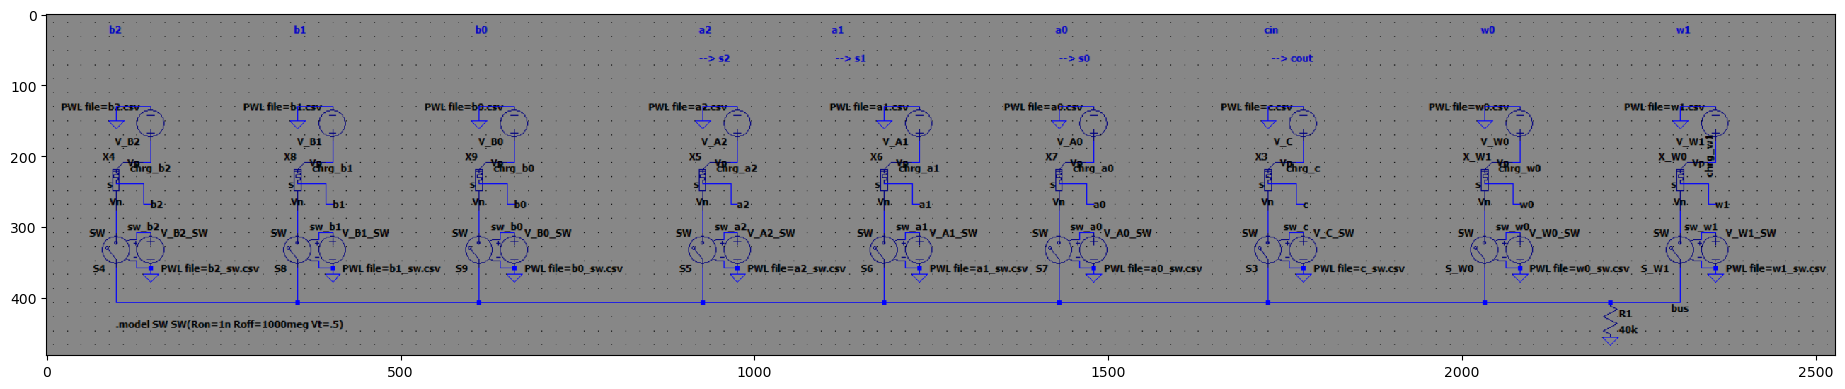

In [3]:
img = mpimg.imread('3BitAdderArch.png')
fig, ax = plt.subplots(figsize=(26, 4))
ax.imshow(img, interpolation='nearest')
plt.tight_layout()

The Architecture is very similar to the 1 Bit adder, but has extra Memrisators for a1, a2, b1 and b2 Inputs.
The Sum bits s0, s1 and s2 are calculated in place and can be found in a0 to a2. The carry Memristor hold carry_in at the beginning but is overwritten during the algorithm wtih the carry_out.

There are only two work memristors (w0 and w1) needed, that are reused per bit, as the algorithm is executed sequentially

### Initial Tests with the 3 Bit Adder using a Python Script to configure the PWL files for the Memristors

see [IMPLY_PWL.py](PWL/IMPLY_PWL.py)

Initial Run: 2 + 3 = 5

In [5]:
memristor_names = ['a0', 'a1', 'a2', 'b0', 'b1', 'b2', 'c', 'w0', 'w1']

step_time = 20

path = 'pwl_files/'

## Use the Memristor class to get access of a collection of functions that can write the PWL file
memristors = [Memristor(name, path) for name in memristor_names]

# dict of memristors mapped by name
m = dict(zip(memristor_names, memristors))

## Use the SerialArchitecture class to get access of a collection of functions that can orchestrate the memristors to create all PWL files
arch = SerialArchitecture(memristors, step_time)

## Set initial state
## Memristors are set to 0 by default
# arch.set_one(m['a0'])
arch.set_one(m['a1'])
# arch.set_one(m['a2'])
arch.set_one(m['b0'])
arch.set_one(m['b1'])
# arch.set_one(m['b2'])
# arch.set_one(m['c'])

# time of initial state configured
init_time = arch.getCurrentTime()
print(init_time)

## Run add algorithm (Bit for Bit)
arch.full_add(m['a0'], m['b0'], m['c'], m['w0'], m['w1'])
arch.full_add(m['a1'], m['b1'], m['c'], m['w0'], m['w1'])
arch.full_add(m['a2'], m['b2'], m['c'], m['w0'], m['w1'])

# close all switches
arch.reset()

## End time
end_time = arch.getCurrentTime()

print(end_time)

arch.print_conf_tocsv()

60
1400


The SerialArchitecture also keeps track of the current time in us for transient simulation and later State extraction. A step size of 20us is chosen arbitrarily.

### Simulation and Result Extraction

Functions to run simulation, plot traces and extract initial and end states

This makes heavily use of the [PyLTSpice](https://pyltspice.readthedocs.io/en/latest/index.html) library

In [ ]:
def runSimulation(sim_time, project_name="3BitAddSerial"):
        runner = SimRunner(output_folder='.', simulator=LTspice)  # Configures the simulator to use and output
        netlist = SpiceEditor("{}.asc".format(project_name))  # Open the Spice Model, and creates the .net
        run_netlist_file = "{}_Sim.net".format(project_name)
        tran = ".tran {}u".format(sim_time) # Set the simulation time
        netlist.add_instructions(
                "; Simulation settings",
                tran
        )
        raw, log = runner.run_now(netlist, run_filename=run_netlist_file)

        return raw

runing simulations [see](https://pyltspice.readthedocs.io/en/latest/modules/run_simulations.html)

In [ ]:
def plotTraces(raw_file, memristor_names, sim_time, split=False):
        raw = RawRead(raw_file)

        if split:
                # get colors from default color cycle
                prop_cycle = plt.rcParams['axes.prop_cycle']
                colors = prop_cycle.by_key()['color']
                # plot a lot of subplots with pretty colors
                fig, axes = plt.subplots(len(memristor_names), figsize=(26, 4*len(memristor_names)), sharex=True)
        else:
                fig, ax = plt.subplots(figsize=(26, 4))

        plt.xlim([0, sim_time*1e-6])

        for name in memristor_names:
                trace = raw.get_trace('V({})'.format(name))
                if split:
                        axes[memristor_names.index(name)].plot(raw.get_axis(), trace.get_wave(), label=name, color=colors[memristor_names.index(name) % len(colors)])
                        axes[memristor_names.index(name)].legend()
                else:
                        ax.plot(raw.get_axis(), trace.get_wave(), label=name)
                        ax.legend()
        
        plt.tight_layout()
        plt.show()

Reading Raw files and plotting traces [see](https://pyltspice.readthedocs.io/en/latest/modules/read_rawfiles.html)

In [ ]:
def extractStates(raw_file, memristor_names, init_time, threshold=0.5, print_results=True):
        raw = RawRead(raw_file)

        for i, time in enumerate(raw.get_axis()):
                if time >= init_time*1e-6:
                        init_idx = i+1   # +1 to get the next index just to be sure
                        break

        result = {}

        for name in memristor_names:

                trace = raw.get_trace('V({})'.format(name))
                
                result[name] = {'init_state': 1 if trace.get_wave()[init_idx] > threshold else 0, 
                                     'init_value': trace.get_wave()[init_idx], 
                                     'end_state': 1 if trace.get_wave()[-1] > threshold else 0, 
                                     'end_value': trace.get_wave()[-1]}
        
        if print_results:
                for key, res in result.items():
                        print(key, 'init:', res['init_state'], 'end', res['end_state'])
                                     
        
        return result

Extract initial and end states from simulation traces. A threshold voltage of 500mV is assumed to be a 1 and 0 otherwise.

This makes use of the `init_time` to get the index within the traces and uses the last index to determine the end state.

### Evaluation

Run simulation for initial conditions

In [ ]:
sim_time = end_time + 100 # 100us after the end of the algorithm
raw_file = runSimulation(sim_time)

Plot results

In [ ]:
plotTraces(raw_file, ['a0', 'a1', 'a2', 'b0', 'b1', 'b2', 'c'], sim_time, split=False)

The algorithm on the serial architecture executes the 1 bit addition in sequence for each bit. At the end the results are in a0, a1, a2 and c.

It takes 66 steps (22n) to execute the algorithm plus 1 step for each bit that is modified in advance (0 -> 1 in our case). Closing all the switches in the end adds another 1 step delay. This is needed to keep the charge of the memristors internal capacitance.

### Input Waveforms

Switching and Charging Activities (This creates an exhaustive collection of plots showing the switching and corresponding charging of each memristor)

In [ ]:
plotTraces(raw_file, ['sw_a0', 'chrg_a0', 'sw_a1', 'chrg_a1', 'sw_a2', 'chrg_a2', 'sw_b0', 'chrg_b0', 'sw_b1', 'chrg_b1', 'sw_b2', 'chrg_b2', 'sw_c', 'chrg_c', 'sw_w0', 'chrg_w0', 'sw_w1', 'chrg_w1'], sim_time, split=True)

The plots show one of three charge operations for every switching of a memristor:
* Charge = -1V: The memristor is pulled to GND : False(A)
* Charge = 1V: The memristor is the destination (consequence) of an implication : X --> A
* Charge = 900mV: The memristor is the source (condition) of an implication : A --> X

Implications must alway occur in condition consequence pairs

Extract initial and end states from traces

In [ ]:
res = extractStates(raw_file, ['a0', 'a1', 'a2', 'b0', 'b1', 'b2', 'c'], init_time, threshold=0.5, print_results=True)

Input: a = 2, b = 3

End State: a = 5, (b still 3), c = 0 (unchanged)

As expected!

### Run Simulation for some inputs

create a function to generate architecture configurations (PWL) with different inputs

In [ ]:
def generatePWL(memristor_names, initial_state, step_size, path='./'):

    ## Use the Memristor class to get access of a collection of functions that can write the PWL file
    memristors = [Memristor(name, path) for name in memristor_names]

    # dict of memristors mapped by name
    m = dict(zip(memristor_names, memristors))

    ## Use the SerialArchitecture class to get access of a collection of functions that can orchestrate the memristors to create all PWL files
    arch = SerialArchitecture(memristors, step_time)

    ## Set initial state
    ## Memristors are set to 0 by default
    for key, state in initial_state.items():
        if state == 1:
            arch.set_one(m[key])


    # time of initial state configured
    init_time = arch.getCurrentTime()

    ## Run add algorithm (Bit for Bit)
    arch.full_add(m['a0'], m['b0'], m['c'], m['w0'], m['w1'])
    arch.full_add(m['a1'], m['b1'], m['c'], m['w0'], m['w1'])
    arch.full_add(m['a2'], m['b2'], m['c'], m['w0'], m['w1'])

    # close all switches
    arch.reset()

    ## End time
    end_time = arch.getCurrentTime()

    arch.print_conf_tocsv()

    return init_time, end_time

Initial states

In [ ]:
initial_states = [
    {'a0': 0, 'a1': 0, 'a2': 0, 'b0': 0, 'b1': 0, 'b2': 0, 'c': 0},
    {'a0': 0, 'a1': 0, 'a2': 1, 'b0': 0, 'b1': 0, 'b2': 0, 'c': 0},
    {'a0': 0, 'a1': 0, 'a2': 1, 'b0': 1, 'b1': 0, 'b2': 1, 'c': 0},
    {'a0': 0, 'a1': 0, 'a2': 1, 'b0': 1, 'b1': 1, 'b2': 1, 'c': 0},
    {'a0': 1, 'a1': 0, 'a2': 0, 'b0': 0, 'b1': 0, 'b2': 0, 'c': 1},
    {'a0': 1, 'a1': 0, 'a2': 1, 'b0': 0, 'b1': 0, 'b2': 0, 'c': 1},
    {'a0': 1, 'a1': 0, 'a2': 1, 'b0': 1, 'b1': 0, 'b2': 1, 'c': 1},
    {'a0': 1, 'a1': 0, 'a2': 1, 'b0': 1, 'b1': 1, 'b2': 1, 'c': 1},
]

In [ ]:
for state in initial_states:
    init_time, end_time = generatePWL(memristor_names, state, 20, path)

    a = state['a0'] + state['a1']*2 + state['a2']*4
    b = state['b0'] + state['b1']*2 + state['b2']*4
    c = state['c']

    total = a + b + c

    print(state, '(Init state: {} + {} (+ Carry {}) = {} + {} = {})'.format(a, b, c, a+b, c, total))

    sim_time = end_time + 100 # 100us after the end of the algorithm
    raw_file = runSimulation(sim_time)
    
    extract_memristor_names = ['a0', 'a1', 'a2', 'b0', 'b1', 'b2', 'c']
    res = extractStates(raw_file, extract_memristor_names, init_time, threshold=0.5, print_results=False)
    # init_state_conf = [res[key]['init_state'] for key in extract_memristor_names]
    # print(dict(zip(extract_memristor_names, init_state_conf)), '(Init state extracted from trace)')
    end_state_conf = [res[key]['end_state'] for key in extract_memristor_names]
    end_state_dict = dict(zip(extract_memristor_names, end_state_conf))
    sum = end_state_dict['a0'] + end_state_dict['a1']*2 + end_state_dict['a2']*4
    total_extracted = sum + end_state_dict['c']*8

    print(end_state_dict, '(End state extracted from trace: {} Carry{} = {})'.format(sum, end_state_dict['c'], total_extracted), 'check!' if total_extracted == total else 'wrong!')

    print()

### Observations and Insights

* LTSpice can be automated with Python
* The Serial Architecture is vastly inefficient with regards to timing (22n) but scales well with regards to area (only 2 memristors per bit plus 1 for carry and 2 work) (2n+3)
* The Serial Architecture is very simple to implement with a 1 Bit adder as a building block
* Only 2 work memristors are needed for the whole algorithm, as the algorithm is executed sequentially